# Corte de raster 

Se importan las librerias necesarias


In [1]:
import rasterio as rio
from rasterio.mask import mask
import shapefile
from osgeo import gdal, gdalnumeric, ogr, osr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import mapping
import os

En este ejemplo se muestra el proceso para el corte del raster wc2.1_30s_bioc_ACCESS-ESM1-5_ssp126_2021-2040.tif
Los rasters pueden descargarse desde la liga https://www.worldclim.org/data/cmip6/cmip6_clim30s.html

In [2]:
src = 'wc2.1_30s_bioc_CNRM-CM6-1_ssp245_2021-2040.tif'
mex = src.replace('wc2.1_30s_bioc', 'mex_bioc') 
print(mex)

mex_bioc_CNRM-CM6-1_ssp245_2021-2040.tif


In [3]:
with rio.open(src) as dataset:

    # sistema de referencia de coordenadas
    crs = dataset.crs

    # geotransform
    transform = dataset.transform

    # fronteras
    bounds = dataset.bounds

    # dimension de raster
    rows, cols = dataset.shape

    # tamaño de pixel
    pixel_size_x = transform[0]
    pixel_size_y = -transform[4]

    # Estas son las propiedades
    print(f"CRS: {crs}")
    print(f"Geotransform: \n {transform}")
    print(f"Fronteras: {bounds}")
    print(f"Cantidad de filas: {rows}")
    print(f"Cantidad de columnas: {cols}")
    print(f"tamaño de pixel: ({pixel_size_x}, {pixel_size_y})")

CRS: EPSG:4326
Geotransform: 
 | 0.01, 0.00,-180.00|
| 0.00,-0.01, 90.00|
| 0.00, 0.00, 1.00|
Fronteras: BoundingBox(left=-180.0, bottom=-90.00000000000011, right=180.00000000000023, top=90.0)
Cantidad de filas: 21600
Cantidad de columnas: 43200
tamaño de pixel: (0.008333333333333338, 0.008333333333333338)


Plot del archivo

In [4]:
#world_raster = rio.open(src)
#plt.imshow(world_raster.read(1), cmap='jet')
#plt.show()

El objetivo principal es que el raster muestre unicamente los pixeles que representan territorio mexicano, para esto es necesario contar con un archivo .shp que represente el contorno de México que sea el "molde" con el que se corte el archivo original. Para esto usamos el archivo 'contdv1mgw.shp' 

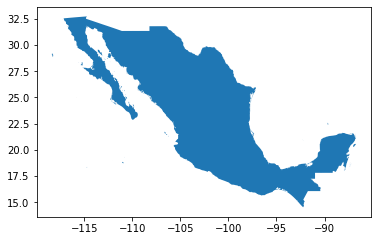

In [5]:
path = os.path.join('contdv1mgw', 'contdv1mgw.shp')
mexico_shapefile = gpd.read_file(path)
mexico_shapefile.plot()
plt.show()

Hay ocaciones en que las coordenadas de los pixeles en el archivo .tif no están en los mismos sistemas de coordenadas que el archivo .shp por lo que antes de hacer el corte se debe corroborar que los CRS's coinciden 

In [6]:
world_raster = rio.open(src)
mexico_shapefile = mexico_shapefile.to_crs(world_raster.crs)


if world_raster.crs == mexico_shapefile.crs:
    print("CRS coinciden  :)")
else:
    print("CRS NO COINCIDEN   :( ")

CRS coinciden  :)


Ahora se puede hacer el corte y guardarlo en la carpeta local, el nombre del archivo se define al principio de la libreta y  el nombre en general es "mex_bioc_" + GCM + ssp + año

In [7]:
mexico_json = mapping(mexico_shapefile.geometry[0])
mexico_raster, transform = mask(world_raster, [mexico_json]*world_raster.count, crop=True)

with rio.open(mex, 'w', driver='GTiff', 
                   height=mexico_raster.shape[1], width=mexico_raster.shape[2], 
                   count=world_raster.count, dtype=mexico_raster.dtype, 
                   crs=world_raster.crs, transform=transform) as dst:
    dst.write(mexico_raster)

Finalmente verificamos que el corte se haya realizado correctamente mediante un plot

mex_bioc_CNRM-CM6-1_ssp245_2021-2040.tif


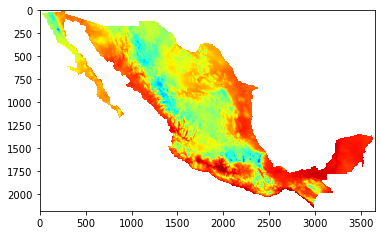

In [8]:
print(mex)
src = rio.open(mex)
plt.imshow(src.read(1), cmap='jet')
plt.show()

info del archivo

In [9]:
layer = gdal.Open('mexico_ssp126_2021-2040.tif')

raster_info = {
                'xsize': layer.RasterXSize,
                'ysize': layer.RasterYSize,
                'geo_transformation': layer.GetGeoTransform(),
                'projection': layer.GetProjection()
              }

data = layer.ReadAsArray()

raster_info

{'xsize': 3648,
 'ysize': 2183,
 'geo_transformation': (-117.1333333333333,
  0.008333333333333338,
  0.0,
  32.724999999999966,
  0.0,
  -0.008333333333333338),
 'projection': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}

In [10]:
data.shape

(19, 2183, 3648)

la variable data consta de 19 matrices, cada una de ellas de dimensión 2183x3648, éstas matrices representa variables bioclimáticas. Para mayor detalle visitar la url https://www.worldclim.org/data/bioclim.html

In [11]:
#Con las descripciones extraidas de worlclim etiquetamos cada layer
descriptions = ['Annual Mean Temperature', 
                'Mean Diurnal Range (Mean of monthly (max temp - min temp))', 
                'Isothermality (BIO2/BIO7) (×100)', 
                'Temperature Seasonality (standard deviation ×100)', 
                'Max Temperature of Warmest Month', 
                'Min Temperature of Coldest Month', 
                'Temperature Annual Range (BIO5-BIO6)', 
                'Mean Temperature of Wettest Quarter', 
                'Mean Temperature of Driest Quarter', 
                'Mean Temperature of Warmest Quarter', 
                'Mean Temperature of Coldest Quarter', 
                'Annual Precipitation', 
                'Precipitation of Wettest Month', 
                'Precipitation of Driest Month', 
                'Precipitation Seasonality (Coefficient of Variation)', 
                'Precipitation of Wettest Quarter', 
                'Precipitation of Driest Quarter', 
                'Precipitation of Warmest Quarter', 
                'Precipitation of Coldest Quarter']
desc_abb= ['AMT', 'MDR', 'ISO', 'TS', 'MTWM', 'MTCM', '(BIO5-BIO6)', 'MTWettQ', 'MDQ', 'MTWarmQ', 'MTCQ', 'AP', 'PWM', 'PDM', 'PSCV', 'PWettQ', 'PDQ', 'PWarmQ', 'PCQ']
desc_dict ={}
abb_dict=[]
for i in range(19):
    desc_dict[descriptions[i]] = desc_abb[i]
    abb_dict.append(desc_abb[i])

Dado que el plot del primer corte sólo muestra la primera de estas 19 matrices se hace plots de cada uno de los layers

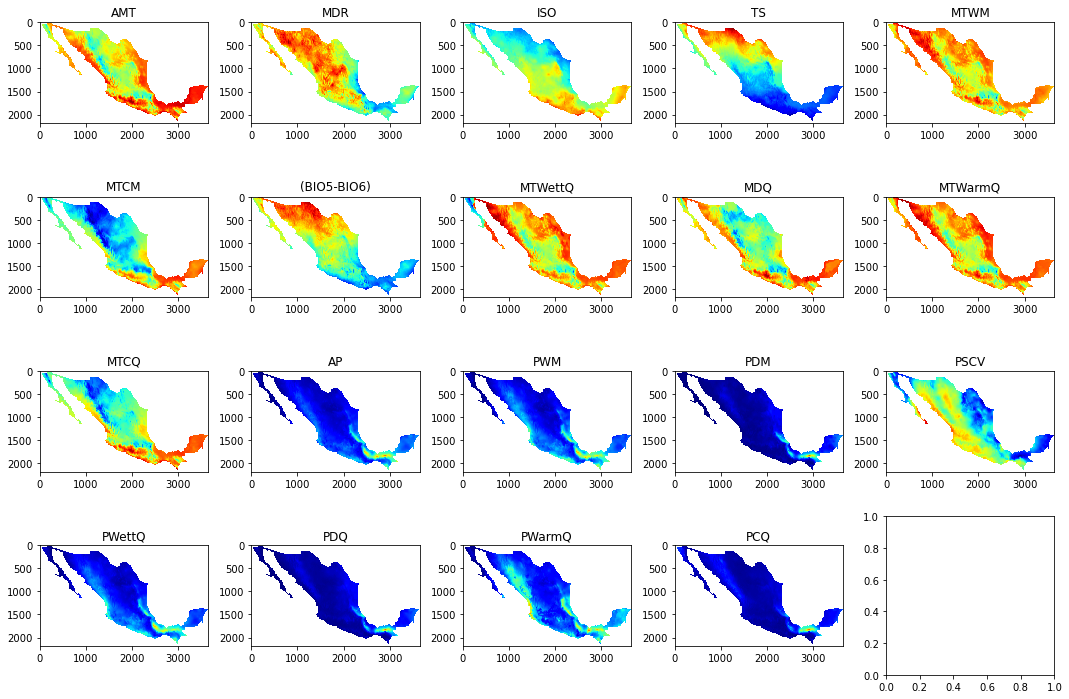

In [12]:
#Realizamos un plot de cada una de las matrices
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
axes = axes.flatten()

for i in range(len(data)):
    ax = axes[i]
    im = ax.imshow(data[i], cmap='jet')
    ax.set_title(desc_abb[i])

fig.tight_layout()
plt.show()